### Name: Tanmay Mane
### Topic: GRU for Language Translation 
### Regd No: 23MSD7021

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/language-translation-englishfrench/eng_-french.csv


In [79]:
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding,Dense, LSTM, Bidirectional,RepeatVector, GRU, Dropout, TimeDistributed
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import SparseCategoricalCrossentropy

import re
from string import punctuation
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [4]:
df  = pd.read_csv('/kaggle/input/language-translation-englishfrench/eng_-french.csv')

In [5]:
df.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [6]:
df.shape

(175621, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175621 entries, 0 to 175620
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   English words/sentences  175621 non-null  object
 1   French words/sentences   175621 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [8]:
#Separating English and French languages.
eng = df['English words/sentences']
fra = df['French words/sentences']

In [9]:
#Word counting - English

eng_word_counter = Counter([word for sentence in eng for word in sentence.split()])
print('Total count of English words: ', len([word for sentence in eng for word in sentence.split()]))
print('Count of Distinct English words: ',len(eng_word_counter))
print('10 Most Common words in English: ',list(zip(*eng_word_counter.most_common(10)))[0])

Total count of English words:  1082098
Count of Distinct English words:  27393
10 Most Common words in English:  ('I', 'to', 'you', 'the', 'a', 'is', 'Tom', 'of', 'in', 'have')


In [10]:
#Word Counting - French

fra_word_counter = Counter([word for sentence in fra for word in sentence.split()])
print('Total count of French words: ', len([word for sentence in fra for word in sentence.split()]))
print('Count of distinct French wors: ',len(fra_word_counter))
print('10 most common words in French: ',list(zip(*fra_word_counter.most_common(10)))[0])

Total count of French words:  1177832
Count of distinct French wors:  44918
10 most common words in French:  ('de', 'Je', '?', 'pas', 'que', 'à', 'ne', 'la', 'le', 'Il')


In [11]:
#Cleaning the text of Punctuations and Unnecessary characters/numbers 

def clean(string):
    string = string.replace("\u202f"," ")
    string = string.lower()
    
    for p in punctuation + "«»" + "0123456789":
        string  =  string.replace(p," ")
        
    string = re.sub('\s+',' ',string)
    return string

In [12]:
eng = eng.apply(lambda x:clean(x))
fra = fra.apply(lambda x:clean(x))

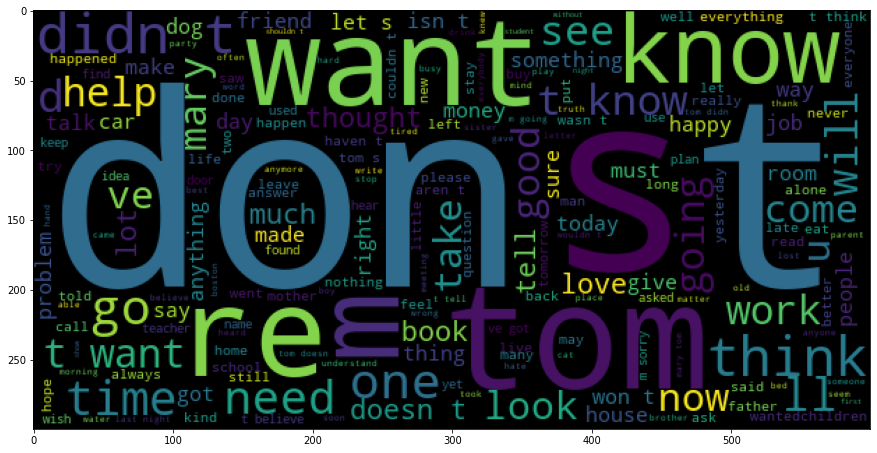

In [13]:
#Creating Wordcloud for the English text

plt.figure(figsize=(15,12))
wc= WordCloud(width=600, height =300).generate(' '.join(eng))
plt.imshow(wc)
plt.show();

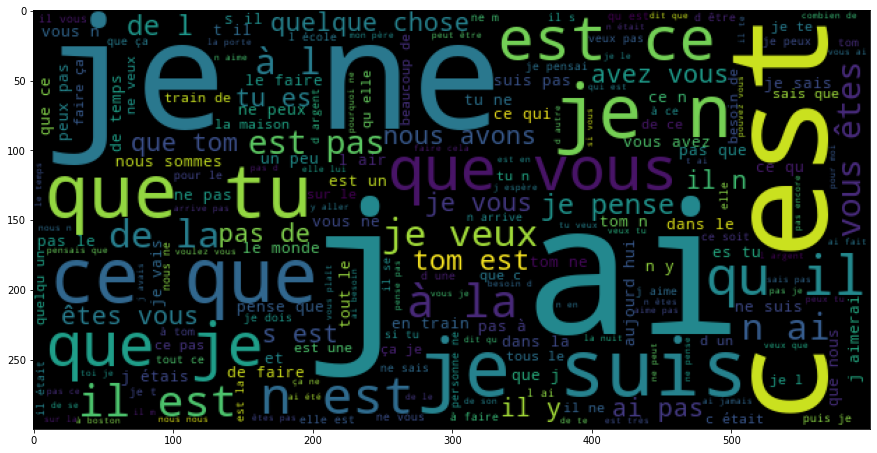

In [14]:
#Creating a wordcloud for French text

plt.figure(figsize=(15,12))
wcf = WordCloud(width=600,height=300).generate(' '.join(fra))
plt.imshow(wcf)
plt.show();

In [17]:
#finding the length of the texts in English and French texts

def word_count(line):
    return len(line.split())

In [18]:
df['English_word_count'] = df['English words/sentences'].apply(lambda x: word_count(x))
df['French_word_count'] = df['French words/sentences'].apply(lambda x: word_count(x))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


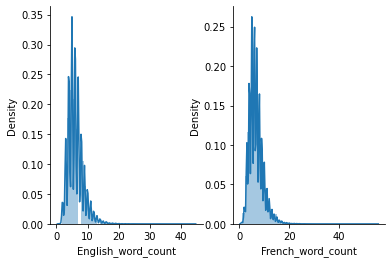

In [19]:
fig, axes = plt.subplots(nrows=1,ncols=2)
sns.distplot(df['English_word_count'],ax=axes[0])
sns.distplot(df['French_word_count'],ax=axes[1])
sns.despine()
plt.show();

Average word count of the english text is about 7-8 words. Maximum reaching 45+. 

While that of the French text seemd to be around same 8-9 words. Maximum reaching around 50+.

In [31]:
#TEXT PREPROCESSING FUNCTIONS FOR MODEL TRAINING

#Tokenizing Text 
def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer


#Finding the maximum sentence length of a language text
def max_sentence_length(lines):
    return max(len(sentence.split()) for sentence in lines)


#Token sequencing and Padding
def encode_sequences(tokenizer,sentences,max_sent_len):
    text_to_seq = tokenizer.texts_to_sequences(sentences)
    text_pad_sequences = pad_sequences(text_to_seq, maxlen = max_sent_len, padding='pre')
    return text_pad_sequences

In [32]:
#For English text - Tokenizer

eng_tokenizer = create_tokenizer(eng)
eng_vocab_size = len(eng_tokenizer.word_index)+1
max_eng_sent_len = max_sentence_length(eng)
print('ENGLISH :')
print('Maximum length of sentence in English :', max_eng_sent_len)
print('English text vocabulary size :', eng_vocab_size)
print('--------------------------------------------')

#For French Text - Tokenizer
fra_tokenizer = create_tokenizer(fra)
fra_vocab_size= len(fra_tokenizer.word_index)+1
max_fra_sent_len = max_sentence_length(fra)
print('FRENCH :')
print('Maximum length of sentence in French :',max_fra_sent_len)
print('French text vocabulary size :',fra_vocab_size)



ENGLISH :
Maximum length of sentence in English : 47
English text vocabulary size : 13922
--------------------------------------------
FRENCH :
Maximum length of sentence in French : 59
French text vocabulary size : 24268


In [70]:
max_eng_sent_len = 25
max_fra_sent_len = 25

#as most of the sentences have 25 or fewer words as seen in the ditsplot above.

In [71]:
#Perform encoding of sequences

X = encode_sequences(eng_tokenizer, eng, max_eng_sent_len)
y = encode_sequences(fra_tokenizer, fra, max_fra_sent_len)

In [72]:
X[777]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  10,  21, 539],
      dtype=int32)

In [73]:
y[777]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         29,   48, 2406], dtype=int32)

In [74]:
#Train test split 

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

### LSTM model

In [77]:
#Model Building - [using Normal LSTM]

def create_model(inp_vocab_size, out_vocab_size, inp_maxlen, out_maxlen):
    model = Sequential()
    model.add(Embedding(inp_vocab_size, 512,input_length = inp_maxlen, mask_zero=True))
    model.add(LSTM(512))
    model.add(RepeatVector(out_maxlen))
    model.add(LSTM(512,return_sequences=True))
    model.add(TimeDistributed(Dense(1024,activation='relu')))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(out_vocab_size,activation='softmax')))
    return model

In [80]:
model = create_model(eng_vocab_size, fra_vocab_size, max_eng_sent_len, max_fra_sent_len)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 25, 512)           7128064   
_________________________________________________________________
lstm_15 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 25, 512)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 25, 512)           2099200   
_________________________________________________________________
time_distributed_12 (TimeDis (None, 25, 1024)          525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 1024)          0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 25, 24268)        

In [84]:
model.compile(loss=SparseCategoricalCrossentropy(),optimizer='adamax',metrics='accuracy')

In [85]:
es = EarlyStopping(monitor='val_accuracy',patience=5,mode='max',verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,mode='max',verbose=1,factor=0.1,min_lr=0.001)

In [86]:
history = model.fit(X_train,
                    y_train.reshape(y_train.shape[0],y_train.shape[1],1),
                    epochs=6,
                    batch_size=512,
                    callbacks=[es,lr],
                    validation_data = (X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))
                   )

Epoch 1/10
275/275 [==============================] - 199s 557ms/step - loss: 1.7855 - accuracy: 0.7242 - val_loss: 1.7331 - val_accuracy: 0.7274
Epoch 2/10
275/275 [==============================] - 152s 554ms/step - loss: 1.6665 - accuracy: 0.7313 - val_loss: 1.6399 - val_accuracy: 0.7340
Epoch 3/10
275/275 [==============================] - 152s 552ms/step - loss: 1.5821 - accuracy: 0.7366 - val_loss: 1.5747 - val_accuracy: 0.7390
Epoch 4/10
275/275 [==============================] - 151s 550ms/step - loss: 1.5136 - accuracy: 0.7416 - val_loss: 1.5133 - val_accuracy: 0.7442
Epoch 5/10
275/275 [==============================] - 152s 551ms/step - loss: 1.4489 - accuracy: 0.7468 - val_loss: 1.4599 - val_accuracy: 0.7488
Epoch 6/10
275/275 [==============================] - 151s 551ms/step - loss: 1.3890 - accuracy: 0.7519 - val_loss: 1.4144 - val_accuracy: 0.7524
Epoch 7/10
275/275 [==============================] - 152s 551ms/step - loss: 1.3330 - accuracy: 0.7568 - val_loss: 1.3590 -

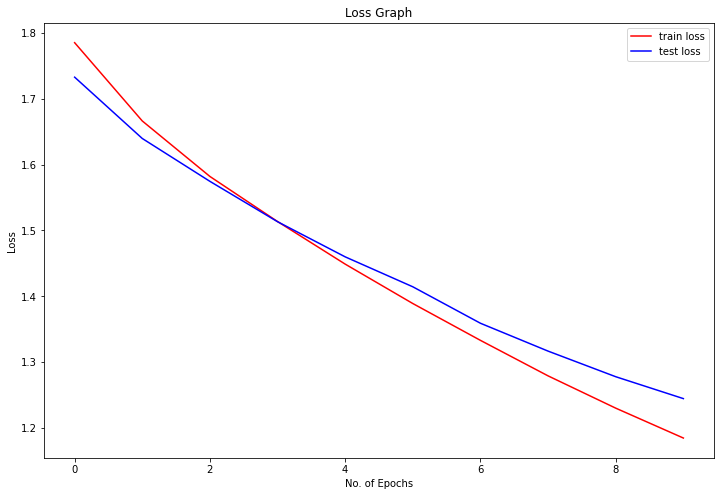

In [87]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

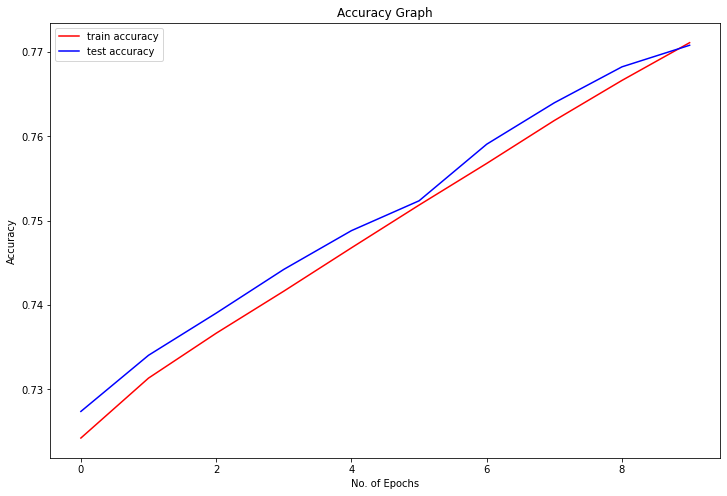

In [88]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [89]:
model.evaluate(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))

1098/1098 [==============================] - 53s 48ms/step - loss: 1.2444 - accuracy: 0.7708


[1.2444344758987427, 0.7708253264427185]

77.1% accuracy 

### Bidirectional LSTM seq2seq

In [91]:
#Model Building - [using Bidirectional LSTM]

def create_model2(inp_vocab_size, out_vocab_size, inp_maxlen, out_maxlen):
    model = Sequential()
    model.add(Embedding(inp_vocab_size, 512,input_length = inp_maxlen, mask_zero=True))
    model.add(Bidirectional(LSTM(512)))
    model.add(RepeatVector(out_maxlen))
    model.add(Bidirectional(LSTM(512,return_sequences=True)))
    model.add(TimeDistributed(Dense(1024,activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(out_vocab_size,activation='softmax')))
    return model

In [92]:
model2 = create_model2(eng_vocab_size, fra_vocab_size, max_eng_sent_len, max_fra_sent_len)
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 25, 512)           7128064   
_________________________________________________________________
lstm_17 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 25, 512)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 25, 512)           2099200   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 25, 1024)          525312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 25, 1024)          0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 25, 24268)        

In [94]:
model2.compile(loss=SparseCategoricalCrossentropy(),optimizer='adamax',metrics='accuracy')

In [95]:
history = model2.fit(X_train,
                    y_train.reshape(y_train.shape[0],y_train.shape[1],1),
                    epochs=10,
                    batch_size=512,
                    callbacks=[es,lr],
                    validation_data = (X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))
                   )

Epoch 1/10
275/275 [==============================] - 200s 696ms/step - loss: 2.1839 - accuracy: 0.7142 - val_loss: 1.8992 - val_accuracy: 0.7185
Epoch 2/10
275/275 [==============================] - 189s 689ms/step - loss: 1.8643 - accuracy: 0.7203 - val_loss: 1.8364 - val_accuracy: 0.7213
Epoch 3/10
275/275 [==============================] - 189s 687ms/step - loss: 1.7968 - accuracy: 0.7232 - val_loss: 1.7749 - val_accuracy: 0.7241
Epoch 4/10
275/275 [==============================] - 190s 689ms/step - loss: 1.7254 - accuracy: 0.7271 - val_loss: 1.7023 - val_accuracy: 0.7291
Epoch 5/10
275/275 [==============================] - 190s 690ms/step - loss: 1.6502 - accuracy: 0.7314 - val_loss: 1.6435 - val_accuracy: 0.7316
Epoch 6/10
275/275 [==============================] - 189s 686ms/step - loss: 1.5820 - accuracy: 0.7355 - val_loss: 1.5673 - val_accuracy: 0.7374
Epoch 7/10
275/275 [==============================] - 189s 687ms/step - loss: 1.5006 - accuracy: 0.7416 - val_loss: 1.4914 -

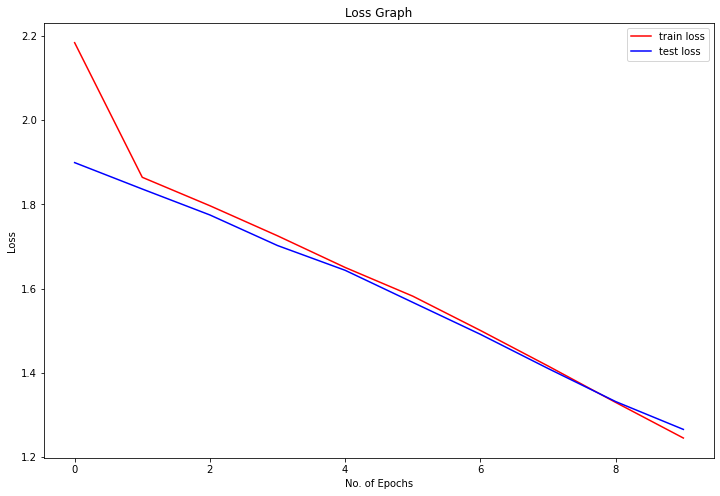

In [96]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

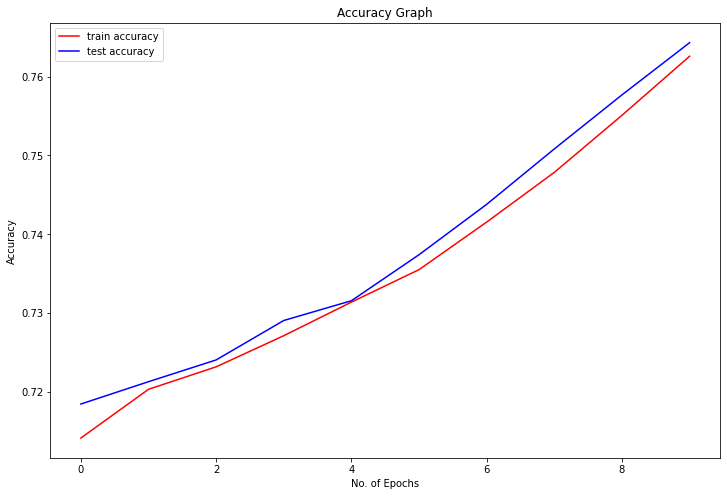

In [97]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [98]:
model2.evaluate(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))

1098/1098 [==============================] - 62s 57ms/step - loss: 1.2657 - accuracy: 0.7643


[1.2657272815704346, 0.7642897963523865]

### Bidirectional-GRU model

In [99]:
def create_model3(inp_vocab_size, out_vocab_size, inp_maxlen, out_maxlen):
    model = Sequential()
    model.add(Embedding(inp_vocab_size, 512,input_length = inp_maxlen, mask_zero=True))
    model.add(Bidirectional(GRU(512)))
    model.add(RepeatVector(out_maxlen))
    model.add(Bidirectional(GRU(512,return_sequences=True)))
    model.add(TimeDistributed(Dense(1024,activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(out_vocab_size,activation='softmax')))
    return model

In [100]:
model3 = create_model3(eng_vocab_size, fra_vocab_size, max_eng_sent_len, max_fra_sent_len)
model3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 25, 512)           7128064   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              3151872   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 25, 1024)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 25, 1024)          4724736   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 25, 1024)          1049600   
_________________________________________________________________
dropout_9 (Dropout)          (None, 25, 1024)          0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 25, 24268)       

In [101]:
model3.compile(loss=SparseCategoricalCrossentropy(),optimizer='adamax',metrics='accuracy')

In [102]:
history3 = model3.fit(X_train,
                    y_train.reshape(y_train.shape[0],y_train.shape[1],1),
                    epochs=10,
                    batch_size=512,
                    callbacks=[es,lr],
                    validation_data = (X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))
                   )

Epoch 1/10
275/275 [==============================] - 194s 675ms/step - loss: 2.2240 - accuracy: 0.7134 - val_loss: 1.8957 - val_accuracy: 0.7186
Epoch 2/10
275/275 [==============================] - 183s 666ms/step - loss: 1.8520 - accuracy: 0.7210 - val_loss: 1.8139 - val_accuracy: 0.7230
Epoch 3/10
275/275 [==============================] - 183s 666ms/step - loss: 1.7659 - accuracy: 0.7250 - val_loss: 1.7377 - val_accuracy: 0.7261
Epoch 4/10
275/275 [==============================] - 183s 667ms/step - loss: 1.6934 - accuracy: 0.7289 - val_loss: 1.6766 - val_accuracy: 0.7312
Epoch 5/10
275/275 [==============================] - 183s 666ms/step - loss: 1.6209 - accuracy: 0.7338 - val_loss: 1.6061 - val_accuracy: 0.7363
Epoch 6/10
275/275 [==============================] - 183s 666ms/step - loss: 1.5470 - accuracy: 0.7387 - val_loss: 1.5410 - val_accuracy: 0.7408
Epoch 7/10
275/275 [==============================] - 183s 666ms/step - loss: 1.4693 - accuracy: 0.7441 - val_loss: 1.4663 -

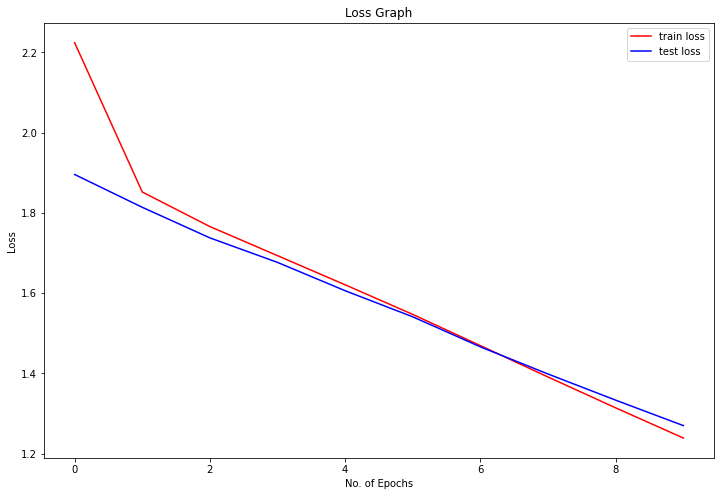

In [103]:
plt.figure(figsize=(12,8))
plt.plot(history3.history['loss'],'r',label='train loss')
plt.plot(history3.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

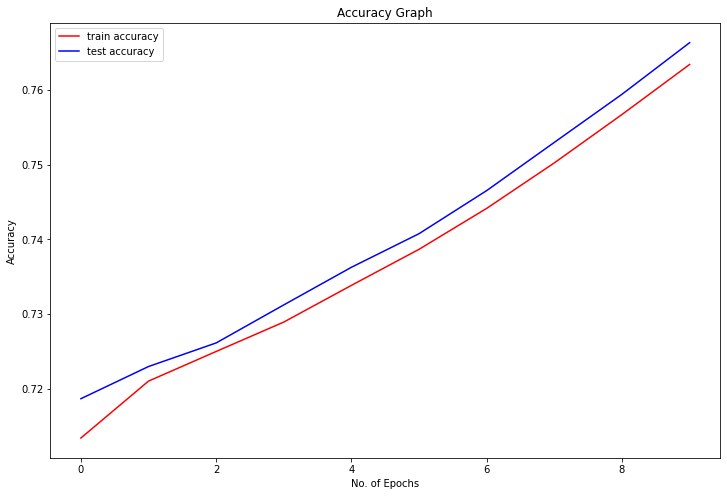

In [104]:
plt.figure(figsize=(12,8))
plt.plot(history3.history['accuracy'],'r',label='train accuracy')
plt.plot(history3.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [105]:
model3.evaluate(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))

1098/1098 [==============================] - 63s 57ms/step - loss: 1.2701 - accuracy: 0.7663


[1.270113468170166, 0.7663499116897583]

### GRU model

In [106]:
def create_model4(inp_vocab_size, out_vocab_size, inp_maxlen, out_maxlen):
    model = Sequential()
    model.add(Embedding(inp_vocab_size, 512,input_length = inp_maxlen, mask_zero=True))
    model.add(GRU(512))
    model.add(RepeatVector(out_maxlen))
    model.add(GRU(512,return_sequences=True))
    model.add(TimeDistributed(Dense(1024,activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(out_vocab_size,activation='softmax')))
    return model

In [107]:
model4 = create_model4(eng_vocab_size, fra_vocab_size, max_eng_sent_len, max_fra_sent_len)
model4.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 25, 512)           7128064   
_________________________________________________________________
gru_2 (GRU)                  (None, 512)               1575936   
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 25, 512)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 25, 512)           1575936   
_________________________________________________________________
time_distributed_20 (TimeDis (None, 25, 1024)          525312    
_________________________________________________________________
dropout_10 (Dropout)         (None, 25, 1024)          0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 25, 24268)       

In [108]:
model4.compile(loss=SparseCategoricalCrossentropy(),optimizer='adamax',metrics='accuracy')

In [109]:
history4 = model4.fit(X_train,
                    y_train.reshape(y_train.shape[0],y_train.shape[1],1),
                    epochs=10,
                    batch_size=512,
                    callbacks=[es,lr],
                    validation_data = (X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))
                   )

Epoch 1/10
275/275 [==============================] - 156s 553ms/step - loss: 2.5737 - accuracy: 0.7104 - val_loss: 1.9766 - val_accuracy: 0.7145
Epoch 2/10
275/275 [==============================] - 150s 546ms/step - loss: 1.9495 - accuracy: 0.7177 - val_loss: 1.9295 - val_accuracy: 0.7184
Epoch 3/10
275/275 [==============================] - 150s 546ms/step - loss: 1.9169 - accuracy: 0.7188 - val_loss: 1.9165 - val_accuracy: 0.7185
Epoch 4/10
275/275 [==============================] - 150s 547ms/step - loss: 1.9031 - accuracy: 0.7190 - val_loss: 1.9012 - val_accuracy: 0.7186
Epoch 5/10
275/275 [==============================] - 150s 547ms/step - loss: 1.8908 - accuracy: 0.7191 - val_loss: 1.9202 - val_accuracy: 0.7182
Epoch 6/10
275/275 [==============================] - 150s 547ms/step - loss: 1.8803 - accuracy: 0.7195 - val_loss: 1.8802 - val_accuracy: 0.7197
Epoch 7/10
275/275 [==============================] - 151s 547ms/step - loss: 1.8647 - accuracy: 0.7201 - val_loss: 1.8637 -

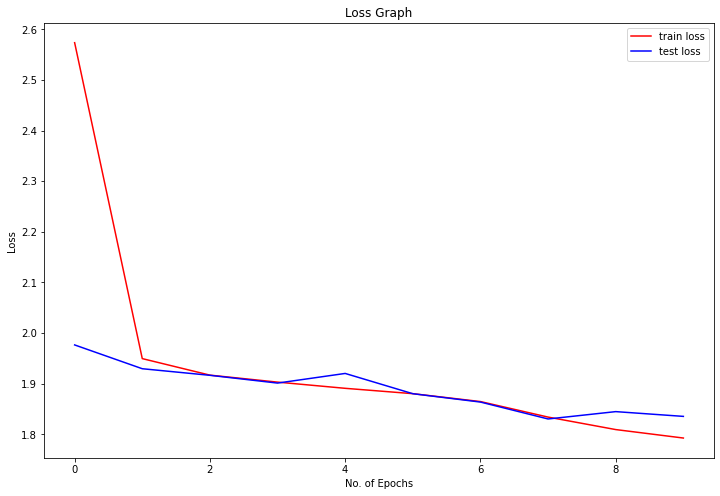

In [110]:
plt.figure(figsize=(12,8))
plt.plot(history4.history['loss'],'r',label='train loss')
plt.plot(history4.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

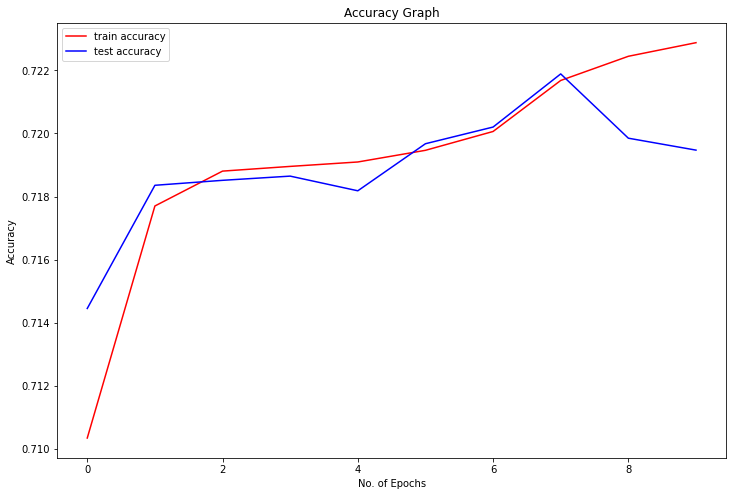

In [111]:
plt.figure(figsize=(12,8))
plt.plot(history4.history['accuracy'],'r',label='train accuracy')
plt.plot(history4.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [112]:
model4.evaluate(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))

1098/1098 [==============================] - 52s 48ms/step - loss: 1.8354 - accuracy: 0.7195


[1.8353796005249023, 0.7194704413414001]